## **Finishing off with Random Forest and Ensemble**

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?"
DB = "products_vectorstore"

In [3]:
load_dotenv(override=True)

True

In [4]:
# Loading the test data

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
results = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(results['embeddings'])
documents = results['documents']
prices = [metadata['price'] for metadata in results['metadatas']]

#### ***What's the Difference?***
```collection.get()```: Returns all documents in the collection as a flat list  

```collection.query()```: Can handle multiple queries at once, so it returns a list of result lists (one per query)

### **Random Forest**  
We'll now train a Random Forest model.  
  
   
In week 6, we used the Word2Vec model to form vectors, this time we'll use the vectors we already have in Chroma, from the SentenceTransformers Model 

In [ ]:
# this line may take a long time to run (almost an hour)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [7]:
# Loading it back again

rf_model = joblib.load('random_forest_model.pkl')

In [8]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [9]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [10]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [11]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $294.80 Truth: $374.41 Error: $79.61 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $205.85 Truth: $225.11 Error: $19.26 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $209.23 Truth: $61.68 Error: $147.55 SLE: 1.46 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $370.22 Truth: $599.99 Error: $229.77 SLE: 0.23 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $213.55 Truth: $16.99 Error: $196.56 SLE: 6.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $56.47 Truth: $31.99 Error: $24.48 SLE: 0.31 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $280.27 Truth: $101.79 Error: $178.48 SLE: 1.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $228.76 Truth: $289.00 Error: $60.24 SLE: 0.05 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $316.39 Truth: $635.86 Error: $319.47 SLE: 0.49 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $173.57 Truth: $65.99 Error: $107.58 SLE

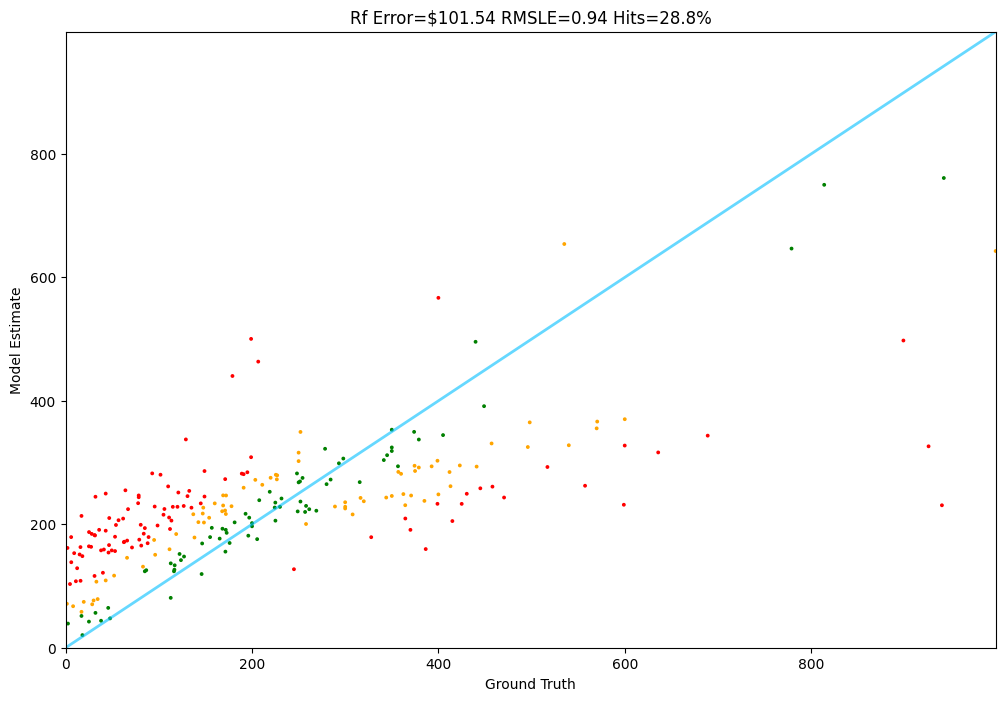

In [16]:
Tester.test(rf, test)

In [12]:
product = "Acer Nitro 5 AMD Ryzen 7 Octa Core 7735HS - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVIDIA GeForce RTX 3050) AN515-47-R093 Gaming Laptop  (15.6 Inch, Obsidian Black, 2.5 Kg)"

In [14]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

950.0
1199.0
575.3693


In [15]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [14:25<00:00,  3.46s/it]


In [16]:
mins = [min(s, f, r) for s,f, r in zip(specialists, frontiers, random_forests)]
maxes = [max(s, f, r) for s, f, r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    "Specialist": specialists, 
    "Frontier": frontiers, 
    "RandomForest": random_forests, 
    "Min": mins, 
    "Max": maxes
})

# Convert y to a series
y = pd.Series(prices)

In [17]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.41
Frontier: 0.14
RandomForest: -0.45
Min: 0.47
Max: 0.41
Intercept=25.97


In [18]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [19]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [20]:
ensemble.price(product)

np.float64(1076.5196787747109)

In [21]:
def ensemble_pricer(item):
    return max(0, ensemble.price(description(item)))

1: Guess: $409.86 Truth: $374.41 Error: $35.45 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $203.96 Truth: $225.11 Error: $21.15 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $51.38 Truth: $61.68 Error: $10.30 SLE: 0.03 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $383.89 Truth: $599.99 Error: $216.10 SLE: 0.20 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $37.35 Truth: $16.99 Error: $20.36 SLE: 0.57 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $39.40 Truth: $31.99 Error: $7.41 SLE: 0.04 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $111.03 Truth: $101.79 Error: $9.24 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $369.35 Truth: $289.00 Error: $80.35 SLE: 0.06 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $887.59 Truth: $635.86 Error: $251.73 SLE: 0.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $74.36 Truth: $65.99 Error: $8.37 SLE: 0.01 Ite

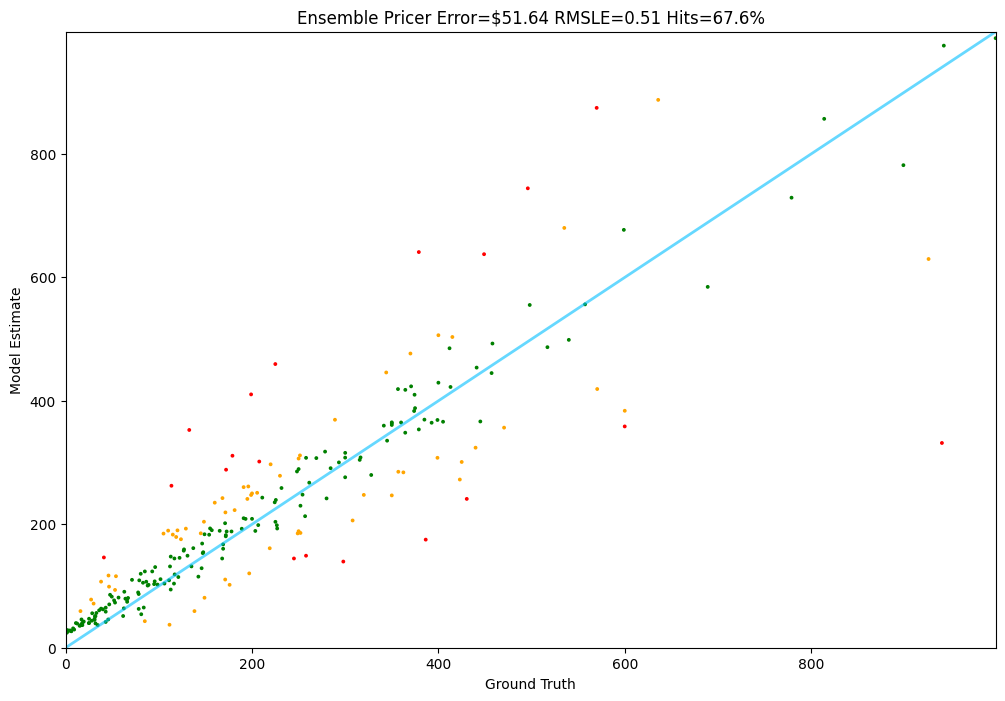

In [22]:
Tester.test(ensemble_pricer, test)